In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
from statsmodels.tsa.stattools import adfuller
from functions.find_bubbles import ADF, PSY

## Detecting bubbles

Based on: https://itamarcaspi.github.io/psymonitor/articles/illustrationSNP.html

In [4]:
snp = pd.read_csv('snp.csv', index_col='date')

In [5]:
y = 1 / snp.value

In [6]:
obs = len(y)
r0 = 0.01 + 1.8/np.sqrt(obs)
swindow0 = int(math.floor(r0*obs))
dim = obs - swindow0 + 1
IC = 2
adflag = 6
yr = 2
Tb = 12*yr + swindow0 - 1
nboot = 99 

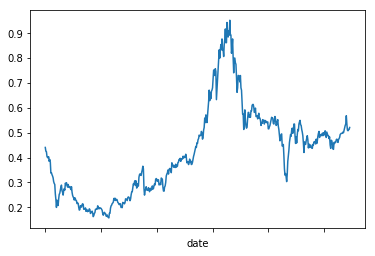

In [7]:
y.plot()

## PSY procedure
Estimate PSY's BSADF sequence of test statistics. Implements the real time bubble detection procedure of Phillips, Shi and Yu (2015a,b)

In [9]:
bsadfs = PSY(y, swindow0, IC, adflag)

## Bootstrap time series using cvPSYwmboot

In [130]:
confidence_levels =  np.array([0.90, 0.95, 0.99])

result = adfuller(data, maxlag=max_lags, regression="c", autolag='BIC', store=True, regresults=True)[-1].resols # list of ADF [beta, errors, lag]
beta = result.params
eps = result.resid
lag = max_lags

T0 = len(eps)
t = len(data)
dy = np.array(data.iloc[0:(t - 1)]) - np.array(data.iloc[1:t])
g = len(beta)

In [131]:
# create matrix filled with random ints < T0 with rows TB and cols: nboot
random_numbers = np.random.randint(0, T0, (control_sample_size, nboot))
# create matrix filled with random normal floats with rows TB and cols: nboot
random_normal_numbers = np.random.normal(1, size=(control_sample_size, nboot))

In [132]:
# dyb = 69 row, 99 col matrix of zeros
dyb = np.zeros([control_sample_size - 1, nboot])
# fill first 6 rows with first six 
dyb[:lag, ] = np.split(np.tile(dy[:lag], nboot), lag, axis=0)

In [168]:
#dyb[5,]

In [199]:
for j in range(nboot):
    # loop over all columns
    if lag == 0:
        for i in range(lag, control_sample_size - 1):
            # loop over rows, start filling the rest of the dyb rows with random numbers
            dyb[i, j] = random_normal_numbers[i - lag, j] * eps[random_numbers[i - lag, j]]
    
    elif lag > 0:
        x = np.zeros([control_sample_size - 1, lag])
        for i in range(lag, control_sample_size - 1):
            # create a new empy array of simlar proportions to dyb
            x = np.zeros([control_sample_size - 1, lag])
            for k in range(lag):
                # every row after the first 6, fill the first six column values with  
                # values of the dyb six rows that came before it
                x[i, k] = dyb[i - k, j]

            # matrix multiplication 
            # fill the rows below the first 6 with 
            # the i row of x * 
            dyb[i, j] = np.dot(x[i, ], beta[1:g]) + random_normal_numbers[i - lag, j] * eps[random_numbers[i - lag, j]]

    

ValueError: shapes (6,) and (3,) not aligned: 6 (dim 0) != 3 (dim 0)

In [197]:
# j = [0 ... 99] (rows)
# i = 6 ... 68 (columns)
# k = lags [0 ... 5]
j = 0
i = 6 
k = 0


beta

array([-0.00331047,  0.21040766,  0.08783607])

In [196]:
eps[random_numbers[i - lag, j]]

0.75122176431020504

In [39]:
# bootstrap procedure
# The Data generating process (DGP)
np.random.seed(101)
# create matrix filled with random ints < T0 with rows TB and cols: nboot
random_numbers = np.random.randint(0, T0, (control_sample_size, nboot))
# create matrix filled with random normal floats with rows TB and cols: nboot
random_normal_numbers = np.random.normal(1, size=(control_sample_size, nboot))

dyb = np.zeros([control_sample_size - 1, nboot])
dyb[:lag, ] = np.split(np.tile(dy[:lag], nboot), lag, axis=0)

for j in range(nboot):
    if lag == 0:
        for i in range(lag + 1,control_sample_size):
            dyb[i, j] = random_normal_numbers[i - lag, j] * eps[random_numbers[i - lag, j]]

    elif lag > 0:
        x = np.zeros(control_sample_size - 1, lag)
        for i in range(lag + 1, control_sample_size):
            x = np.zeros(control_sample_size - 1, lag)
            for k in range(lag):
                x[i, k] = dyb[(i - k), j]

            # matrix multiplication
            dyb[i, j] = np.dot(x[i, ], beta[2:g, 1] + random_normal_numbers[i - lag, j] * eps[random_numbers[i - lag, j]])


yb0 = np.repeat(y[1], repeats=nboot)
dyb0 = np.concatenate(yb0, dyb)
yb = apply(dyb0, 2, np.cumsum)


Date
1973.03    17.412142
1973.04    16.935740
1973.05    16.314339
1973.06    15.808323
1973.07    15.889519
1973.08    15.278501
1973.09    15.475309
1973.10    15.913516
1973.11    14.651845
1973.12    13.493330
1974.01    13.530722
1974.02    12.957321
1974.03    13.310364
1974.04    12.550411
1974.05    11.995437
1974.06    11.888499
1974.07    10.394142
1974.08     9.824196
1974.09     8.680421
1974.10     8.744984
1974.11     8.948985
1974.12     8.289060
1975.01     8.920996
1975.02     9.762247
1975.03    10.163797
1975.04    10.233076
1975.05    10.818139
1975.06    11.011355
1975.07    10.902767
1975.08    10.089770
             ...    
2016.02    24.002607
2016.03    25.372299
2016.04    25.922338
2016.05    25.694710
2016.06    25.840373
2016.07    26.694003
2016.08    26.948872
2016.09    26.727873
2016.10    26.525143
2016.11    26.850954
2016.12    27.865098
2017.01    28.063574
2017.02    28.655107
2017.03    29.086922
2017.04    28.904246
2017.05    29.313345
2017.06 

## Implementing the functions etc to detect bubbles

In [74]:
t = len(data)
# len data is 647
# min window = 47

bsadfs = np.zeros([t, 1]) # create empty column array at lenght of the data (zeros)

for r2 in range(min_window, t + 1):
    # loop over the range 47 - 647
    # create column vector of increasing lenght and fill with - 999
    rwadft = np.ones([r2 - min_window + 1, 1]) * -999
    for r1 in range(r2 - min_window + 1):
        # loop over the range 0 - 500
        # perform ADF test on data from r1 --> r2
        # insert in row
        rwadft[r1] = float(adfuller(data.iloc[r1:r2], maxlag=max_lags, autolag='BIC')[0]) # two tail 5% significant level
        
    # take max value an insert in bsadfs array
    bsadfs[r2 - 1] = max(rwadft.T[0])

# create shortened version of array
bsadf = bsadfs[min_window:t]


In [81]:
PSY(data, min_window, max_lags)

array([[ -2.76950482e+00],
       [ -2.70494583e+00],
       [ -2.60547957e+00],
       [ -2.41605590e+00],
       [ -2.27034771e+00],
       [ -2.29337915e+00],
       [ -2.32595803e+00],
       [ -2.27018936e+00],
       [ -2.25753827e+00],
       [ -2.24566129e+00],
       [ -2.18819465e+00],
       [ -2.24042018e+00],
       [ -2.24887278e+00],
       [ -1.93571147e+00],
       [ -1.85563223e+00],
       [ -1.54916580e+00],
       [ -1.71744668e+00],
       [ -1.83194529e+00],
       [ -1.74883795e+00],
       [ -1.66080183e+00],
       [ -1.43273823e+00],
       [ -1.43512351e+00],
       [ -1.36789478e+00],
       [ -1.38167461e+00],
       [ -8.68648381e-01],
       [ -9.05382523e-01],
       [ -7.31610807e-01],
       [ -7.57473460e-01],
       [ -8.15121242e-01],
       [ -6.15990336e-01],
       [ -5.08293942e-01],
       [ -5.02688787e-01],
       [ -6.67137345e-01],
       [ -6.72509539e-01],
       [ -4.29200179e-01],
       [ -3.34075826e-01],
       [ -5.21839181e-01],
 

In [80]:
def PSY(y, swindow0, adflag):
    """
    Estimate PSY's BSADF sequence of test statistics
    implements the real time bubble detection procedure of Phillips, Shi and Yu (2015a,b)
    
    param: y: np.array of the data
    param: swindow0: integer minimum window size 
    param: adflag: An integer, lag order when IC=0; maximum number of lags when IC>0 (default = 0).
    
    For every period in time calculate the max ADF statistic using a rolling window. 
    
    return: list BSADF test statistic.
    """
    t = len(y)
    
    if not swindow0: 
        swindow0 = int(math.floor(t * (0.01 + 1.8 / np.sqrt(t))))

    bsadfs = np.zeros([t, 1]) # create empty column array at lenght of the data (zeros)

    for r2 in range(swindow0, t + 1):
    # loop over the range 47 - 647
    # create column vector of increasing lenght and fill with - 999
        rwadft = np.ones([r2 - swindow0 + 1, 1]) * -999
        for r1 in range(r2 - swindow0 + 1):
            # loop over the range 0 - 500
            # perform ADF test on data from r1 --> r2
            # insert in row
            rwadft[r1] = float(adfuller(y.iloc[r1:r2], maxlag=adflag, autolag='BIC')[0]) # two tail 5% significant level
        
        # take max value an insert in bsadfs array
        bsadfs[r2 - 1] = max(rwadft.T[0])

    # create shortened version of array
    bsadf = bsadfs[swindow0:t]
    
    return bsadf

In [ ]:
def cvPSYwmboot(y, swindow0, adflag, Tb, nboot, nCores = 2):  # IC = 'BIC'
    """
    Computes a matrix of 90, 95 and 99 critical values which can be used to compare to the bsadf statistics.
    
    
    
    return: A matrix. BSADF bootstrap critical value sequence at the 90, 95 and 99 percent level.
    """